# Import and settings

In [11]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import logging
import logzero
from logzero import logger


# examination settings
batch_size = 128
test_batch_size = batch_size * 2
epochs = 100
lr = 0.5
momentum = 0.9
seed = 2017
log_interval = 1000
num_workers = 2
use_gpu = False
ex_name = 'supervised'

# set seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# logger setting
LOG_FORMAT = '[%(asctime)s %(levelname)s] %(message)s'
logzero.loglevel(logging.INFO)
logzero.logfile('./log/{}.log'.format(ex_name))
logzero.formatter(logging.Formatter(LOG_FORMAT))

# Prepare data

In [2]:
train_dataset = datasets.MNIST('./data/MNIST/train/', download=True, train=True)
test_dataset = datasets.MNIST('./data/MNIST/test/', download=True, train=False)

train_data = train_dataset.train_data.numpy()
test_data = test_dataset.test_data.numpy()
train_labels = train_dataset.train_labels.numpy()
test_labels = test_dataset.test_labels.numpy()

In [3]:
print(len(train_labels), len(test_labels))

60000 10000


## Change the ratio train/test
train:val:test を 800:200:69000に設定。各クラスのサンプル数は均一に。testセットは実際に教師なし学習に用いることは想定しづらいので、現実のタスクや論文に書く時はunlabeledデータとして説明すれば良い。その場合はtestセット内で更に unlabeled/holdout に分ける必要がある。
交差検証は行わない。

pseudo label実験に対してはtestデータはunlabeledデータ及び最終評価用のデータとして使われる。valは学習中の精度監視用。

In [4]:
n_train = 1000
n_val = 1000
n_test = 68000

X_train = np.empty(shape=(0, 28, 28))
y_train = np.empty(shape=(0,))
X_val = np.empty(shape=(0, 28, 28))
y_val = np.empty(shape=(0,))
X_test = np.empty(shape=(0, 28, 28))
y_test = np.empty(shape=(0,))

for i in range(10):
    idx_train = np.argwhere(train_labels == i)[:(n_train//10)].squeeze()
    idx_val = np.argwhere(train_labels == i)[(n_train//10):((n_train+n_val)//10)].squeeze()
    idx_test = np.argwhere(train_labels == i)[((n_train+n_val)//10):].squeeze()
    
    X_train = np.concatenate([X_train, train_data[idx_train]], axis=0)
    y_train = np.concatenate([y_train, train_labels[idx_train]], axis=0)
    X_val = np.concatenate([X_val, train_data[idx_val]], axis=0)
    y_val = np.concatenate([y_val, train_labels[idx_val]], axis=0)
    X_test = np.concatenate([X_test, train_data[idx_test]], axis=0)
    y_test = np.concatenate([y_test, train_labels[idx_test]], axis=0)
    
X_test = np.concatenate([X_test, test_data], axis=0)
y_test = np.concatenate([y_test, test_labels], axis=0)

# treat as image
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

# one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [5]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1000, 28, 28, 1) (1000, 10) (1000, 28, 28, 1) (1000, 10) (68000, 28, 28, 1) (68000, 10)


# Define a network

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.adaptive_max_pool2d(x, output_size=1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x

# Define Dataset, DataLoader

In [17]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.X[index]
        img = self.transform(img)
        target = torch.Tensor(self.y[index].astype(float))
        return img, target
    
    def __len__(self):
        return self.X.shape[0]
    

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = MNISTDataset(X_train, y_train, transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_dataset = MNISTDataset(X_val, y_val, transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=test_batch_size, num_workers=num_workers)
test_dataset = MNISTDataset(X_test, y_test, transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, num_workers=num_workers)

# Define TrainingTracker

In [9]:
class TrainingTracker(object):
    def __init__(self):
        self.epoch = 0
        self.history = {
            'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []
        }
        self.reset()
        
    def reset(self):
        self.train_acc = 0
        self.train_loss = 0
        self.val_acc = 0
        self.val_loss = 0
        self.train_count = 0
        self.val_count = 0

    def update(self, train, acc, loss, n):
        if train:
            acc_sum = self.train_acc * self.train_count + acc * n
            loss_sum = self.train_loss * self.train_count + loss * n
            self.train_count += n
            self.train_acc = acc_sum / self.train_count
            self.train_loss = loss_sum / self.train_count
        else:
            acc_sum = self.val_acc * self.val_count + acc * n
            loss_sum = self.val_loss * self.val_count + loss * n
            self.val_count += n
            self.val_acc = acc_sum / self.val_count
            self.val_loss = loss_sum / self.val_count

    def plot_history(self):
        plt.plot(self.history['train_acc'])
        plt.plot(self.history['val_acc'])
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['train_acc', 'val_acc'], loc='lower right')
        plt.show()

        plt.plot(self.history['train_loss'])
        plt.plot(self.history['val_loss'])
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['train_loss', 'val_loss'], loc='lower right')
        plt.show()

# Define train, validate, test function

In [16]:
def _train(model, data_loader, criterion, optimizer, tracker):
    model.train()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()

def _validate(model, data_loader, criterion, tracker):
    model.eval()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=False, acc=acc, loss=loss.data[0], n=len(X))

    logger.info(
        'Epoch: {tracker.epoch} | '
        'ValAcc: {tracker.val_acc:.4f} | '
        'ValLoss: {tracker.val_loss:.4f} \n'.format(
            tracker=tracker)
    )
    tracker.history['val_acc'].append(tracker.val_acc)
    tracker.history['val_loss'].append(tracker.val_loss)
    tracker.reset()
    
def _test(model, data_loader, criterion, make_pl=False):
    model.eval()
    
    if make_pl:
        pseudo_label = np.empty((0, 10))
    
    acc_sum = 0
    loss_sum = 0
    for i, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc_sum += pred.eq(answer).sum()
        loss_sum += loss.data[0] * X.size(0)
        
        if make_pl:
            pseudo_label = np.concatenate([pseudo_label, output.data.numpy()], axis=0)

    acc = acc_sum / n_test
    loss = loss_sum / n_test
    logger.info(
        'TestAcc: {0:.4f} | '
        'TestLoss: {1:.4f} '.format(
            acc, loss)
    )
    
    if make_pl:
        pseudo_label = np.exp(pseudo_label)
        np.save('./save/pseudo_label.npy'.format(ex_name), pseudo_label)

# Do training

[2017-12-02 18:27:50,090 INFO] Epoch: 0 | TrainAcc: 0.1150 | TrainLoss: 0.2382
[2017-12-02 18:27:50,421 INFO] Epoch: 0 | ValAcc: 0.2330 | ValLoss: 0.2268 

[2017-12-02 18:27:51,105 INFO] Epoch: 1 | TrainAcc: 0.2480 | TrainLoss: 0.2186
[2017-12-02 18:27:51,468 INFO] Epoch: 1 | ValAcc: 0.1870 | ValLoss: 0.2185 

[2017-12-02 18:27:52,147 INFO] Epoch: 2 | TrainAcc: 0.2960 | TrainLoss: 0.2000
[2017-12-02 18:27:52,484 INFO] Epoch: 2 | ValAcc: 0.3630 | ValLoss: 0.1939 

[2017-12-02 18:27:53,147 INFO] Epoch: 3 | TrainAcc: 0.4270 | TrainLoss: 0.1703
[2017-12-02 18:27:53,480 INFO] Epoch: 3 | ValAcc: 0.3170 | ValLoss: 0.1920 

[2017-12-02 18:27:54,145 INFO] Epoch: 4 | TrainAcc: 0.5160 | TrainLoss: 0.1428
[2017-12-02 18:27:54,482 INFO] Epoch: 4 | ValAcc: 0.4780 | ValLoss: 0.1437 

[2017-12-02 18:27:55,167 INFO] Epoch: 5 | TrainAcc: 0.6230 | TrainLoss: 0.1156
[2017-12-02 18:27:55,506 INFO] Epoch: 5 | ValAcc: 0.5440 | ValLoss: 0.1255 

[2017-12-02 18:27:56,233 INFO] Epoch: 6 | TrainAcc: 0.6780 | Tra

[2017-12-02 18:28:43,317 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 18:28:43,648 INFO] Epoch: 52 | ValAcc: 0.8840 | ValLoss: 0.0399 

[2017-12-02 18:28:44,331 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 18:28:44,653 INFO] Epoch: 53 | ValAcc: 0.8840 | ValLoss: 0.0404 

[2017-12-02 18:28:45,341 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 18:28:45,682 INFO] Epoch: 54 | ValAcc: 0.8830 | ValLoss: 0.0407 

[2017-12-02 18:28:46,368 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 18:28:46,675 INFO] Epoch: 55 | ValAcc: 0.8820 | ValLoss: 0.0405 

[2017-12-02 18:28:47,294 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 18:28:47,628 INFO] Epoch: 56 | ValAcc: 0.8840 | ValLoss: 0.0402 

[2017-12-02 18:28:48,283 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 18:28:48,636 INFO] Epoch: 57 | ValAcc: 0.8830 | ValLoss: 0.0404 

[2017-12-02 18:28:49,315 INFO] Epoch: 58 | TrainAcc:

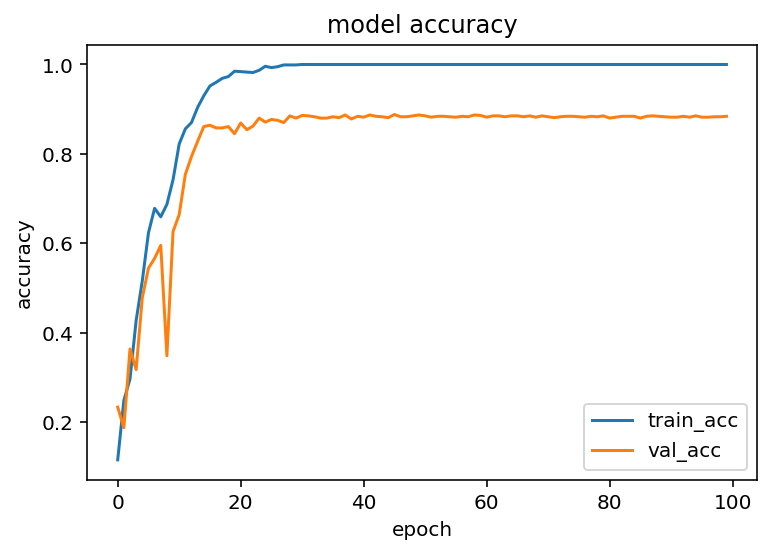

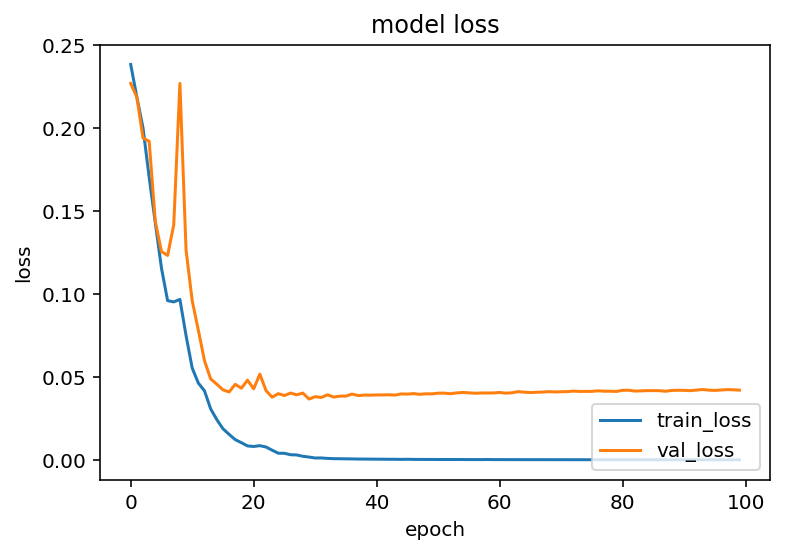

In [12]:
model = Net()
if use_gpu:
    model.cuda()

def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
    torch.save(state, filename)
    #shutil.copyfile(filename, 'model_best.pth.tar')
    
criterion = nn.KLDivLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
tracker = TrainingTracker()

for epoch in range(0, epochs):
    tracker.epoch = epoch
    
    _train(model, train_loader, criterion, optimizer, tracker)
    _validate(model, val_loader, criterion, tracker)
    
    # if latest accuracy is the best in history
    if np.argmax(tracker.history['val_acc']) == len(tracker.history['val_acc']) - 1:
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        })
    
logger.info('Train done.')
tracker.plot_history()

# Make Pseudo Label

In [15]:
model = Net()
resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
model.load_state_dict(resume['state_dict'])
_test(model, test_loader, criterion, make_pl=True)

100%|██████████| 266/266 [00:14<00:00, 18.12it/s]
[2017-12-02 18:34:41,183 INFO] TestAcc: 0.8940 | TestLoss: 0.0371 
